<a href="https://colab.research.google.com/github/Abby263/cv-projects/blob/main/Pedestrian_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TorchVision Instance Segmentation Finetuning Tutorial

For this tutorial, we will be finetuning a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model in the [*Penn-Fudan Database for Pedestrian Detection and Segmentation*](https://www.cis.upenn.edu/~jshi/ped_html/). It contains 170 images with 345 instances of pedestrians, and we will use it to illustrate how to use the new features in torchvision in order to train an instance segmentation model on a custom dataset.

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [1]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ih1qqala
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-ih1qqala


In [2]:
# import the necessary packages
import os
import cv2
import time
from tqdm import tqdm
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
from torchvision import transforms
from torch.optim import Adam
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet50
from torch.nn import Dropout, Identity, Linear, Module, ReLU, Sequential, Sigmoid, MSELoss, CrossEntropyLoss



### Writing a custom dataset for Penn-Fudan

Let's write a dataset for the Penn-Fudan dataset.

First, let's download and extract the data, present in a zip file at https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

In [3]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

--2022-08-05 04:55:15--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip.1’

PennFudanPed.zip.1  100%[===================>]  51.23M  27.4MB/s    in 1.9s    

2022-08-05 04:55:17 (27.4 MB/s) - ‘PennFudanPed.zip.1’ saved [53723336/53723336]

--2022-08-05 04:55:17--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2022-08-05 04:55:17--
Total wall clock time: 2.3s
Downloaded: 1 files, 51M in 1.9s (27.4 MB/s)
Archive:  PennFudanPed.zip
replace PennFudanPed/added-object-list.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: PennFudanPed/added-object-list.txt  
  inflating: PennFudanPed/Annotation/FudanPed00001

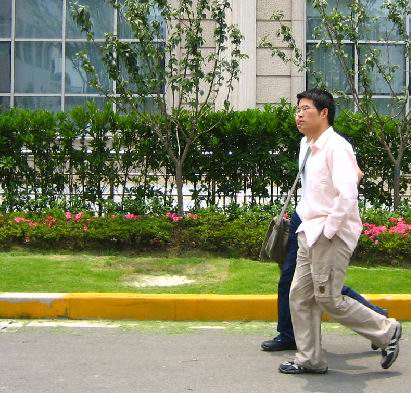

In [4]:
show_img = Image.open('PennFudanPed/PNGImages/FudanPed00010.png')
show_img

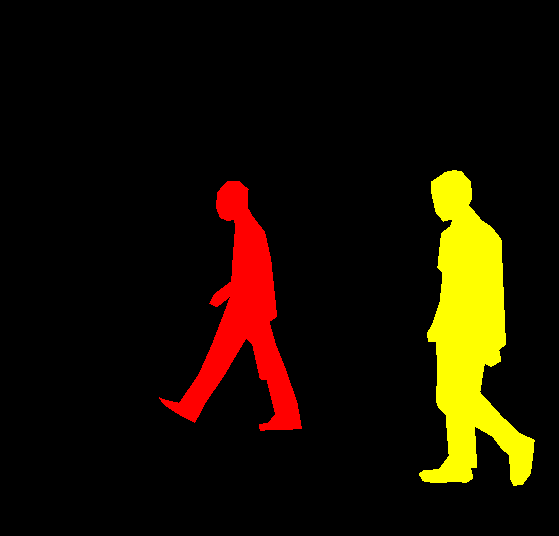

In [5]:
mask = Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

In [6]:
# import the necessary packages
class CONFIG :
  # define the base path to the input dataset and then use it to derive
  # the path to the input images and annotation CSV files
  BASE_PATH = "/content/PennFudanPed"
  IMAGES_PATH = os.path.sep.join([BASE_PATH, "PNGImages"])
  ANNOTS_PATH = os.path.sep.join([BASE_PATH, "annotations"])
  # define the path to the base output directory
  BASE_OUTPUT = "/content"
  # define the path to the output model, label encoder, plots output
  # directory, and testing image paths
  MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.pth"])
  LE_PATH = os.path.sep.join([BASE_OUTPUT, "le.pickle"])
  PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "plots"])
  TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])
  # determine the current device and based on that set the pin memory
  # flag
  DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
  PIN_MEMORY = True if DEVICE == "cuda" else False
  # specify ImageNet mean and standard deviation
  MEAN = [0.485, 0.456, 0.406]
  STD = [0.229, 0.224, 0.225]
  # initialize our initial learning rate, number of epochs to train
  # for, and the batch size
  INIT_LR = 1e-4
  NUM_EPOCHS = 20
  BATCH_SIZE = 32
  # specify the loss weights
  LABELS = 1.0
  BBOX = 1.0

In [7]:
# import the necessary packages
class CustomTensorDataset(Dataset):
    # initialize the constructor
    def __init__(self, tensors, transforms=None):
        self.tensors = tensors
        self.transforms = transforms


    def __getitem__(self, index):
        # grab the image, label, and its bounding box coordinates
        image = self.tensors[0][index]
        label = self.tensors[1][index]
        bbox = self.tensors[2][index]
        # transpose the image such that its channel dimension becomes
        # the leading one
        image = image.permute(2, 0, 1)
        # check to see if we have any image transformations to apply
        # and if so, apply them
        if self.transforms:
            image = self.transforms(image)
        # return a tuple of the images, labels, and bounding
        # box coordinates
        return (image, label, bbox)


    def __len__(self):
        # return the size of the dataset
        return self.tensors[0].size(0)

In [8]:
class ObjectDetector(Module):
  def __init__(self, baseModel, numClasses):
    super(ObjectDetector, self).__init__()
		# initialize the base model and the number of classes
    self.baseModel = baseModel
    self.numClasses = numClasses
  
    # build the regressor head for outputting the bounding box
		# coordinates
    self.regressor = Sequential(
			Linear(baseModel.fc.in_features, 128),
			ReLU(),
			Linear(128, 64),
			ReLU(),
			Linear(64, 32),
			ReLU(),
			Linear(32, 4),
			Sigmoid()
		)
  
    # build the classifier head to predict the class labels
    self.classifier = Sequential(
			Linear(baseModel.fc.in_features, 512),
			ReLU(),
			Dropout(),
			Linear(512, 512),
			ReLU(),
			Dropout(),
			Linear(512, self.numClasses)
		)
		# set the classifier of our base model to produce outputs
		# from the last convolution block
    self.baseModel.fc = Identity()
  
  def forward(self, x):
		# pass the inputs through the base model and then obtain
		# predictions from two different branches of the network
    features = self.baseModel(x)
    bboxes = self.regressor(features)
    classLogits = self.classifier(features)
		# return the outputs as a tuple
    return (bboxes, classLogits)

In [9]:
print("[INFO] loading dataset...")
data = []
labels = []
bboxes = []
imagePaths = []

image_path = os.path.join('/content/PennFudanPed', "PNGImages")
mask_path = os.path.join('/content/PennFudanPed', "PedMasks")
images_list = sorted([os.path.join(image_path, file)
        for file in os.listdir(image_path)
        if file.endswith('.png')])

masks_list = sorted([os.path.join(mask_path, file) 
        for file in os.listdir(mask_path) 
        if file.endswith('.png')])

for i in range(len(images_list)):
  # image = cv2.imread(images_list[i])
  
  # load the image and preprocess it
  image = cv2.imread(images_list[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (224, 224))

  (h, w) = image.shape[:2]
  

  mask = Image.open(masks_list[i])
  # convert the PIL Image into a numpy array
  mask = np.array(mask)
  obj_ids = np.unique(mask)
  # first id is the background, so remove it
  obj_ids = obj_ids[1:]
  # split the color-encoded mask into a set
  # of binary masks
  masks = mask == obj_ids[:, None, None]
  # get bounding box coordinates for each mask
  num_objs = len(obj_ids)
  boxes = []
  for i in range(num_objs):
      pos = np.where(masks[i])
      xmin = np.min(pos[1])
      xmax = np.max(pos[1])
      ymin = np.min(pos[0])
      ymax = np.max(pos[0])

      # scale the bounding box coordinates relative to the spatial
      # dimensions of the input image
      startX = float(xmin) / w
      startY = float(ymin) / h
      endX = float(xmax) / w
      endY = float(ymax) / h

      # update our list of data, class labels, bounding boxes, and
      # image paths
      data.append(image)
      labels.append(1)
      bboxes.append((startX, startY, endX, endY))
      

[INFO] loading dataset...


In [10]:
# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
# perform label encoding on the labels
le = LabelEncoder()
labels = le.fit_transform(labels)

In [11]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, labels, bboxes,
	test_size=0.20, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]


# convert NumPy arrays to PyTorch tensors
(trainImages, testImages) = torch.tensor(trainImages),\
	torch.tensor(testImages)
(trainLabels, testLabels) = torch.tensor(trainLabels),\
	torch.tensor(testLabels)
(trainBBoxes, testBBoxes) = torch.tensor(trainBBoxes),\
	torch.tensor(testBBoxes)
 
# define normalization transforms
transforms = transforms.Compose([
	transforms.ToPILImage(),
	transforms.ToTensor(),
	transforms.Normalize(mean=CONFIG.MEAN, std=CONFIG.STD)
])
 
 # convert NumPy arrays to PyTorch datasets
trainDS = CustomTensorDataset((trainImages, trainLabels, trainBBoxes),
	transforms=transforms)
testDS = CustomTensorDataset((testImages, testLabels, testBBoxes),
	transforms=transforms)

print("[INFO] total training samples: {}...".format(len(trainDS)))
print("[INFO] total test samples: {}...".format(len(testDS)))

# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // CONFIG.BATCH_SIZE
valSteps = len(testDS) // CONFIG.BATCH_SIZE

# create data loaders
trainLoader = DataLoader(trainDS, batch_size=CONFIG.BATCH_SIZE,
	shuffle=True, num_workers=os.cpu_count(), pin_memory=CONFIG.PIN_MEMORY)
testLoader = DataLoader(testDS, batch_size=CONFIG.BATCH_SIZE,
	num_workers=os.cpu_count(), pin_memory=CONFIG.PIN_MEMORY)

# # write the testing image paths to disk so that we can use then
# # when evaluating/testing our object detector
# print("[INFO] saving testing image paths...")
# f = open(CONFIG.TEST_PATHS, "w")
# f.write("\n".join(testPaths))
# f.close()

# load the ResNet50 network
resnet = resnet50(pretrained=True)
# freeze all ResNet50 layers so they will *not* be updated during the
# training process
for param in resnet.parameters():
	param.requires_grad = False

# create our custom object detector model and flash it to the current
# device
objectDetector = ObjectDetector(resnet, len(le.classes_))
objectDetector = objectDetector.to(CONFIG.DEVICE)
# define our loss functions
classLossFunc = CrossEntropyLoss()
bboxLossFunc = MSELoss()
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(objectDetector.parameters(), lr=CONFIG.INIT_LR)
# print(objectDetector)
# initialize a dictionary to store training history
H = {"total_train_loss": [], "total_val_loss": [], "train_class_acc": [],
	 "val_class_acc": []}



[INFO] total training samples: 338...
[INFO] total test samples: 85...


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# load the ResNet50 network
resnet = resnet50(pretrained=True)
# freeze all ResNet50 layers so they will *not* be updated during the
# training process
for param in resnet.parameters():
	param.requires_grad = False

# create our custom object detector model and flash it to the current
# device
objectDetector = ObjectDetector(resnet, 2)
objectDetector = objectDetector.to(CONFIG.DEVICE)
# define our loss functions
classLossFunc = CrossEntropyLoss()
bboxLossFunc = MSELoss()
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(objectDetector.parameters(), lr=CONFIG.INIT_LR)

# initialize a dictionary to store training history
H = {"total_train_loss": [], "total_val_loss": [], "train_class_acc": [],
	 "val_class_acc": []}

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(2)):
    # set the model in training mode
    objectDetector.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0
    # loop over the training set
    for (images, labels, bboxes) in trainLoader:
        # send the input to the device
        (images, labels, bboxes) = (images.to(CONFIG.DEVICE),
                                    labels.to(CONFIG.DEVICE), 
                                    bboxes.to(CONFIG.DEVICE))
        # perform a forward pass and calculate the training loss
        predictions = objectDetector(images)
        # print(f'predictions : {predictions}')
        classLoss = classLossFunc(predictions[1], labels)
        bboxLoss = bboxLossFunc(predictions[0], bboxes)
        totalLoss = (CONFIG.BBOX * bboxLoss) + (CONFIG.LABELS * classLoss)
        # zero out the gradients, perform the backpropagation step,
        # and update the weights
        opt.zero_grad()
        totalLoss.backward()
        opt.step()
        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += totalLoss
        trainCorrect += (predictions[1].argmax(1) == labels).type(
            torch.float).sum().item()

    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        objectDetector.eval()
        # loop over the validation set
        for (images, labels, bboxes) in testLoader:
            # send the input to the device
            (images, labels, bboxes) = (images.to(CONFIG.DEVICE),
                                        labels.to(CONFIG.DEVICE), bboxes.to(CONFIG.DEVICE))
            # make the predictions and calculate the validation loss
            predictions = objectDetector(images)
            bboxLoss = bboxLossFunc(predictions[0], bboxes)
            classLoss = classLossFunc(predictions[1], labels)
            totalLoss = (CONFIG.BBOX * bboxLoss) + \
                        (CONFIG.LABELS * classLoss)
            totalValLoss += totalLoss
            # calculate the number of correct predictions
            valCorrect += (predictions[1].argmax(1) == labels).type(
                torch.float).sum().item()

    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    # calculate the training and validation accuracy
    trainCorrect = trainCorrect / len(trainDS)
    valCorrect = valCorrect / len(testDS)
    # update our training history
    H["total_train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_class_acc"].append(trainCorrect)
    H["total_val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_class_acc"].append(valCorrect)
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, CONFIG.NUM_EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
        avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(
        avgValLoss, valCorrect))
    endTime = time.time()
    print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))

[INFO] training the network...


 50%|█████     | 1/2 [01:27<01:27, 87.82s/it]

[INFO] EPOCH: 1/20
Train loss: 1.254471, Train accuracy: 0.9497
Val loss: 1.190228, Val accuracy: 1.0000
[INFO] total time taken to train the model: 87.83s


100%|██████████| 2/2 [02:54<00:00, 87.06s/it]

[INFO] EPOCH: 2/20
Train loss: 0.848291, Train accuracy: 1.0000
Val loss: 1.032132, Val accuracy: 1.0000
[INFO] total time taken to train the model: 174.13s


[INFO] saving object detector model...
[INFO] saving label encoder...


FileNotFoundError: ignored

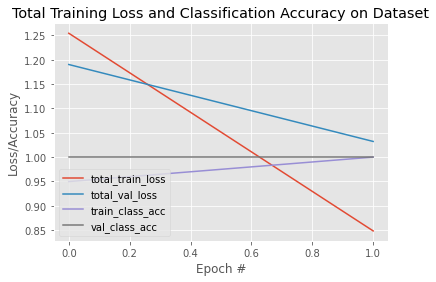

In [17]:
import pickle
import matplotlib.pyplot as plt

# serialize the model to disk
print("[INFO] saving object detector model...")
torch.save(objectDetector, CONFIG.MODEL_PATH)
# serialize the label encoder to disk
print("[INFO] saving label encoder...")
f = open(CONFIG.LE_PATH, "wb")
f.write(pickle.dumps(le))
f.close()
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["total_train_loss"], label="total_train_loss")
plt.plot(H["total_val_loss"], label="total_val_loss")
plt.plot(H["train_class_acc"], label="train_class_acc")
plt.plot(H["val_class_acc"], label="val_class_acc")
plt.title("Total Training Loss and Classification Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# save the training plot
plotPath = os.path.sep.join([CONFIG.PLOTS_PATH, "training.png"])
plt.savefig(plotPath)